# Example pipeline
This example pipeline trains a model that can be used for challenge.

In [62]:
# Classifier imports
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.utils import resample
from sklearn.ensemble import RandomForestRegressor

import os.path
import pylab as plt
import pandas as pd
import numpy as np

from joblib import dump, load

# 1. Read data
First download the data files by following [the instructions](https://github.com/eyra/fertility-prediction-challenge#preparation).

In [63]:
# Data paths; the LISS data files that you've downloaded should be placed in the `data` folder
# (where the `fake_data.csv` is located).
data_folder_path = "C://Users//Startklar//Downloads"
path_train = os.path.join(data_folder_path, "LISS_example_input_data.csv")
path_outcome = os.path.join(data_folder_path, "LISS_example_groundtruth_data.csv")

In [64]:
# Read data
full_data = pd.read_csv(path_train, encoding="cp1252", low_memory=False)
outcome = pd.read_csv(path_outcome, encoding="cp1252", low_memory=False)

# Drop observations where the outcome is missing
y_isna = outcome['new_child'].isnull()
full_data = full_data.loc[~y_isna]
outcome = outcome.loc[~y_isna]

# 2. Split data into train and test
First thing always, otherwise you risk overfitting.

In [65]:
X_train, X_test, y_train, y_test = train_test_split(
    full_data,
    outcome,
    test_size=0.1, random_state=2023)
y_train = y_train["new_child"]
y_test = y_test["new_child"]

# 3. Pre-process and model
You may not want to include the preprocessing in the pipeline if it becomes too cumbersome.

Make sure to use the scoring that you want to optimize in the search space.

In [77]:
# Pre-pre process (keep some columns)
keepcols = ['gebjaar', 'geslacht', 'leeftijd2019',
            'aantalhh2019','partner2019', 'sted2019', 'belbezig2019', 
            'nettoink2019', 'oplmet2019', 'herkomstgroep2019',
            'burgstat2019', 'leeftijd2019', 'woonvorm2019', 'oplmet2019', 'aantalki2019']
data = full_data.loc[:, keepcols]

In [86]:
y_upsample, X_upsample = resample(y_train[y_train == 1],
                                          X_train[y_train == 1],
             replace=True,
             n_samples=len(outcome),
             random_state=42)

#add upsample to dataset
y_upsampled = pd.concat([y_upsample, y_train[y_train==0]])
X_upsampled = pd.concat([X_upsample, X_train[y_train==0]])

In [87]:
# Create transformers
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='infrequent_if_exist'))])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# Use ColumnTransformer to apply the transformations to the correct columns in the dataframe
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, selector(dtype_exclude=object)(data)),
        ('cat', categorical_transformer, selector(dtype_include=object)(data))])

In [91]:
# Create pipeline
model = Pipeline([
               ("preprocess", preprocessor),
               ("classifier", RandomForestClassifier())
               ]) 
                      
# Define the hyperparameters
#parameters = [
#    {
#        'classifier': [LogisticRegression(max_iter=500)],
#        'classifier__C': np.logspace(-1, 5, 50)
#    },
#    
#
#]

# Perform hyperparameter tuning using cross-validation
#grid_search = GridSearchCV(model, parameters, cv=5, n_jobs=-1, scoring="f1", verbose=3)
#grid_search.fit(X_upsampled, y_upsampled)

# Keep best model
#best_model = grid_search.best_estimator_
best_model = model.fit(X_upsampled, y_upsampled)
best_model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['gebjaar', 'leeftijd2019',
                                                   'nettoink2019',
                                                   'leeftijd2019']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist'))]),
                                                  ['geslacht', 'aantalhh2019',
                                                   'partner2019', 'sted2019',
                                                   'belbezig2019', 'oplmet2019',
                                                   'herkomstgroep2019',
                                                   'burgstat2019',
                                                   'woonvorm2019', 'oplmet2019',
                                                   'aantalki2019'])])),
                ('classifier', RandomForestClassifier())])

# Evaluate the model

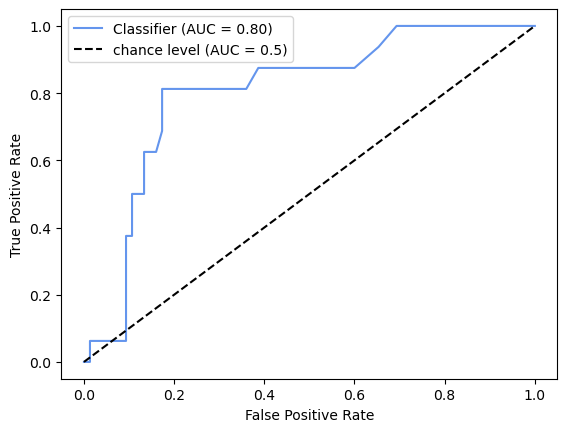

In [92]:
RocCurveDisplay.from_predictions(
    y_test,
    best_model.predict_proba(X_test)[:, 1],
    color="cornflowerblue",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [93]:
# Create predictions
y_pred = best_model.predict(X_test)

# Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.89      0.89        75
         1.0       0.47      0.44      0.45        16

    accuracy                           0.81        91
   macro avg       0.67      0.67      0.67        91
weighted avg       0.81      0.81      0.81        91



# Save models
The model needs to be saved to disk. This allows the benchmarking script to load it and use it for predictions.

In [96]:
models_path = os.path.join("C://Users//Startklar//Downloads")
os.makedirs(models_path, exist_ok=True)

# Dump model (don't change the name)
dump(best_model, os.path.join(models_path, "model.joblib"))

['C://Users//Startklar//Downloads\\model.joblib']

# How the submission would look like
The snippet below is taken from the file `src/script.py`. It shows how the prediction code needs to work. The function will be called with a dataframe containing the full dataset. This dataset is similar to the data downloaded but also includes the holdout data.

It then does the preprocessing in the same way that was used to train the model. If you make any adjustments to the pre-processing they should also be copied to the `src/script.py` script (**the code below is just an excerpt**).

Finally the script loads the model that was saved in the step above and does the prediction.

In [73]:
def predict_outcomes(df):
    # Keep 
    keepcols = ['burgstat2019', 'leeftijd2019', 'woonvorm2019', 'oplmet2019', 'aantalki2019']
    nomem_encr = df["nomem_encr"]
    
    df = df.loc[:, keepcols]
    
    # Load your trained model from the models directory
    model_path = os.path.join(os.path.dirname(__file__), "..", "models", "model.joblib")
    model = load(model_path)

    # Use your trained model for prediction
    predictions = model.predict(df)
    # Return the result as a Pandas DataFrame with the columns "nomem_encr" and "prediction"
    return pd.concat([nomem_encr, pd.Series(predictions, name="prediction")], axis=1)